<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Tunning </h1> 
</div>

![](img/header.png)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (features) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no [notebook anterior](https://github.com/rogeriodelfim/Competicoes/blob/main/Flai/10/02%20-%20Features%20Engineering.ipynb) com XGBoost na competição. 



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    !pip install --q tensorflow
    !pip install --q wandb
    !pip install --q eli5
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import shap
import multiprocessing
import glob
import scipy.optimize 
import scipy.special
import optuna

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import statsmodels.api   as sm
import xgboost           as xgb
import lightgbm          as lgb
import scikitplot        as skplt
import category_encoders as ce

In [4]:
from matplotlib.axes._axes      import _log as matplotlib_axes_logger
from sklearn.model_selection    import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing      import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing      import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing      import PowerTransformer, Normalizer
from sklearn.preprocessing      import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                    import metrics
from sklearn.metrics            import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score
from sklearn.metrics            import classification_report, confusion_matrix
from datetime                   import datetime
from sklearn.feature_selection  import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from colorama                   import Fore, Back, Style
from collections                import Counter

In [5]:
from sklearn.compose            import ColumnTransformer, make_column_transformer
from sklearn.pipeline           import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection  import VarianceThreshold
from sklearn.impute             import SimpleImputer
from scipy.stats                import chi2_contingency
from plotly.subplots            import make_subplots
from sklearn.base               import BaseEstimator, TransformerMixin, clone

In [6]:
from sklearn.metrics            import precision_score
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import recall_score
from sklearn.metrics            import fbeta_score
from sklearn.metrics            import f1_score
from sklearn.metrics            import log_loss
from sklearn.impute             import SimpleImputer
from category_encoders          import TargetEncoder

In [7]:
from imblearn.over_sampling     import SMOTE
from imblearn.under_sampling    import RandomUnderSampler
from sklearn.ensemble           import RandomForestClassifier

In [8]:
from optuna.samplers            import TPESampler
from optuna.visualization       import plot_edf
from optuna.visualization       import plot_optimization_history
from optuna.visualization       import plot_parallel_coordinate
from optuna.visualization       import plot_param_importances
from optuna.visualization       import plot_slice
from optuna.visualization       import plot_intermediate_values
from optuna.visualization       import plot_contour
from optuna.pruners             import MedianPruner
from optuna.pruners             import BasePruner
from optuna.trial._state        import TrialState
from optuna.integration         import XGBoostPruningCallback
from feature_engine.selection   import DropConstantFeatures, DropDuplicateFeatures

In [9]:
from sklearn.ensemble           import ExtraTreesClassifier  
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.ensemble           import HistGradientBoostingClassifier
from sklearn.neural_network     import MLPClassifier
from sklearn                    import set_config

## 1.3. Funções

Abaixo foi criado uma classe com diversas funções, que será utilizada nos processos e modelagem.

In [10]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = 1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = 1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = 1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = 1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [11]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

In [12]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [13]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, target_, level_='1', cutoff_value_=.6, gera_submission_=True, 
                    is_tunning_=False):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:            
            if is_tunning_==False:
                df_sub = pd.DataFrame({target_: np.zeros(len(y_pred_test_submission_))})
                df_sub[target_] = y_pred_test_submission_
                df_sub.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [14]:
def plot_metric(result):
    plt.figure(figsize=(16, 4))
    
    for i, metric in enumerate(['logloss']):
        plt.subplot(1, 2, i+1)
        train_metric = result['train'][metric]
        plt.plot(train_metric, label=f'train {metric}')
        eval_metric = result['valid'][metric]
        plt.plot(eval_metric, label=f'valid {metric}')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel(f'{metric}')
    plt.show()

In [15]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_, seed_=12359, print_report_=False,
                 n_splits_=5, print_hist_=False, create_sub_=False, save_ensamble_=True,
                 model_feature_=None, is_tunning_=False, callbacks_=None, train_with_created_folds_=False):
    
    cols         = []
    cols_score   = []
    mdl_list_fit = []
    tag          = 90
    oof_train    = np.zeros((len(X_), len(models_)))
    score_mdl    = np.zeros(len(models_),)
    oof_test     = np.zeros((len(X_test_), len(models_)))
    kf           = [] 
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        for i in range(n_splits_):         
            kf.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(n_splits_, i+1)))
    else:        
        kf = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)
        kf = kf.split(X_, y_)

    for i, m in enumerate(models_):
        
        time_start       = datetime.now()
        model            = m[1]
        type_model       = m[2]
        name_sub         = m[3]
        n_estimators     = m[5]
        score_list       = []
        score_list_f1    = []
        score_list_f1_tr = []
        y_ts_pred        = 0 
                
        
        if is_tunning_ is False:
            delete_files(name_sub)
            print()
            print('=> {}'.format(m[0]))
            print('='*tag)

        for fold, (idx_tr, idx_va) in enumerate(kf): #enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            X_ts            = X_test_.copy()
            
            if train_with_created_folds_:
                idx_tr = kf[fold][idx_tr]
                idx_va = kf[fold][idx_va]
                
            X_tr = X_.iloc[idx_tr]
            X_va = X_.iloc[idx_va]
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if model_feature_ is not None:
                X_tr_ = X_tr.copy()
                X_va_ = X_va.copy()
                X_ts_ = X_ts.copy()
                if model_feature_[1] is not None:
                    X_tr_ = model_feature_[1].fit_transform(X_tr, y_tr)
                    X_va_ = model_feature_[1].transform(X_va)
                    X_ts_ = model_feature_[1].transform(X_ts)
                    
                model_feature_[0].fit(X_tr_, y_tr)
                
                X_tr['fe_model'] = model_feature_[0].predict_proba(X_tr_)[:,1]
                X_va['fe_model'] = model_feature_[0].predict_proba(X_va_)[:,1]
                X_ts['fe_model'] = model_feature_[0].predict_proba(X_ts_)[:,1]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_ts)
                
                model.fit(X_tr, y_tr,
                          model__eval_set=[(X_va, y_va)],
                          #model__eval_metric ='binary_logloss',
                          #model__callbacks=[early_stopping_rounds=100]
                          model__early_stopping_rounds=50,
                          model__verbose              = False)
            
            if type_model==3:
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
                                
            if type_model==4:
                pp_processor = m[4]
                X_tr = pp_processor.fit_transform(X_tr, y_tr)
                X_va = pp_processor.transform(X_va)
                X_ts = pp_processor.transform(X_test_.copy())
                model.fit(X_tr, y_tr,
                          eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                          early_stopping_rounds = int(n_estimators*.3),
                          verbose               = False)
                
                
            if type_model==5:
                pp_processor = m[4]
                X_tr_ = pp_processor.fit_transform(X_tr, y_tr)
                X_va_ = pp_processor.transform(X_va)
                X_ts_ = pp_processor.transform(X_test_.copy())
                if callbacks_ is not None:
                    model.fit(X_tr, y_tr,
                              model__eval_set              = [(X_tr_, y_tr), (X_va_, y_va)],
                              model__early_stopping_rounds = int(n_estimators*.3),
                              model__callbacks             = [callbacks_] ,
                              model__verbose               = False)
                else: 
                     model.fit(X_tr, y_tr,
                              eval_set              = [(X_tr, y_tr), (X_va, y_va)],
                              early_stopping_rounds = int(n_estimators*.3),
                              verbose               = False)

                    
            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_tr_pred  = model.predict_proba(X_tr)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/n_splits_ #kf.n_splits
            
            logloss    = log_loss(y_va, y_va_pred)
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            f1_tr      = f1_score(y_tr, (y_tr_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            if is_tunning_ is False:
                msg = "Fold {} => F1-score: {:2.5f} - F1-Train: {:2.5f} - AUC:{:2.5f} - L.Loss: {:2.5f} - {}"
                print(msg.format(fold+1, f1, f1_tr, roc_auc, logloss, time_fold_end))
            
            score_list_f1.append(f1)
            score_list_f1_tr.append(f1_tr)
            score_list.append(logloss)
            
            mdl_list_fit.append ([m[0], fold+1, model])

        oof_test[:,i]     = y_ts_pred
        score_mean        = np.mean(score_list).round(5)
        score_mean_f1     = np.mean(score_list_f1).round(5)
        score_mean_f1_tr  = np.mean(score_list_f1_tr).round(5)        
        score_mean_f1_std = np.std(score_list_f1).round(5)
                
        if print_hist_: 
            plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean_f1))
    
        if create_sub_:
            random = str(np.random.rand(1)[0]).replace('.','')
            
            if target_ is None: target_=target
                
            if is_tunning_ is False:
                name_sub = name_sub+'_score_{:5f}_seed_{}_folds_{}_oof'.format(score_mean_f1, seed_, n_splits_)
            else: 
                name_sub = name_sub+'_score_{:5f}_seed_{}_{}'.format(score_mean_f1, seed_, random)
                
            y_pred_test_sub = (oof_test[:,i]>.5).astype(int)
            
            y_pred_test_submission_=[]
            for num in y_pred_test_sub: 
                y_pred_test_submission_.append('não' if num==0 else 'sim')
            
            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = y_pred_test_submission_, 
                            score_                  = score_mean_f1, 
                            seed_                   = seed_, 
                            level_                  = '1', 
                            target_                 = target_, 
                            cutoff_value_           = .65, 
                            is_tunning_             = is_tunning_,
                            gera_submission_        = True)  
        
        
        score_mdl[i] = score_mean_f1
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        msg = '{}{}[Mean] => F1-score: {:.5f} (+-{}) - F1-Train: {:.5f} - L.Loss: {:.5f} - {}{}'
        
        if is_tunning_ is False:
            print('-'*tag)
            print(msg.format(Fore.GREEN, Style.BRIGHT, score_mean_f1, score_mean_f1_std, 
                             score_mean_f1_tr, score_mean, time_end, Style.RESET_ALL)) 
            print('='*tag)

            if print_report_: 
                y_pred = (oof_train[:, i]>.5).astype(int)
                print()
                print(classification_report(y_, y_pred))
                print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
    
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score)
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=False)
    
    if is_tunning_ is False:        
        if save_ensamble_:
            jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr.pkl.z')
            jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts.pkl.z');

        print()
    
        display(df_score_mdl)
    
    return mdl_list_fit, df_oof_tr, df_oof_ts, df_score_mdl, score_mean_f1 

## 1.4. Criar estrutura de pasta 


In [16]:
path        = '/content/drive/MyDrive/Curso/Flai/10/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'produto'
path_automl = 'automl/'

utility.create_fold(path)

set_config(display="diagram")

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [17]:
df1_train     = jb.load(path + path_data + 'pkl/df_train_fe.pkl.z')
df1_test      = jb.load(path + path_data + '/pkl/df_test_fe.pkl.z')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((5685, 16), (5685, 16), (5685, 1))

### 1.5.3. Visualizar os dados 

In [18]:
df1_train.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,anterior,idade_group,ncontatos_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,gerência,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,nenhum,Acima_35_e_Menor_Igual_45,"(0.999, 2.0]",1.312926,1,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,nenhum,Entre_29_35,"(3.0, 5.0]",2.793892,3,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,nenhum,Acima_45_e_Menor_Igual_55,"(0.999, 2.0]",1.651909,1,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,nenhum,Menor_29,"(0.999, 2.0]",-0.920503,0,0
4,gerência,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,apenas um,Entre_29_35,"(0.999, 2.0]",-3.251812,0,1


In [19]:
df1_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,anterior,idade_group,ncontatos_group,fe_pca_0,fe_cluster_bgmm_pca,produto
0,gerência,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,nenhum,Acima_35_e_Menor_Igual_45,"(0.999, 2.0]",1.312926,1,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,nenhum,Entre_29_35,"(3.0, 5.0]",2.793892,3,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,nenhum,Acima_45_e_Menor_Igual_55,"(0.999, 2.0]",1.651909,1,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,nenhum,Menor_29,"(0.999, 2.0]",-0.920503,0,0
4,gerência,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,apenas um,Entre_29_35,"(0.999, 2.0]",-3.251812,0,1


In [20]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5685 entries, 0 to 5699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trabalho             5463 non-null   object 
 1   estado civil         5672 non-null   object 
 2   educação             5443 non-null   object 
 3   atraso               4662 non-null   object 
 4   casa                 5547 non-null   object 
 5   empréstimo           5547 non-null   object 
 6   contato              5685 non-null   object 
 7   mês                  5685 non-null   object 
 8   dia                  5685 non-null   object 
 9   duração              5685 non-null   object 
 10  anterior             5685 non-null   object 
 11  idade_group          5685 non-null   object 
 12  ncontatos_group      5685 non-null   object 
 13  fe_pca_0             5685 non-null   float64
 14  fe_cluster_bgmm_pca  5685 non-null   int64  
 15  produto              5685 non-null   i

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. PROCESSAMENTO </h1>    
</div>

In [21]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

map_cluster = {0:'cluster_1', 1:'cluster_2', 2:'cluster_3', 3:'cluster_4'}
df2_train['fe_cluster_bgmm_pca'] = df2_train['fe_cluster_bgmm_pca'].map(map_cluster)
df2_test['fe_cluster_bgmm_pca']  = df2_test['fe_cluster_bgmm_pca'].map(map_cluster)

df2_train.rename(columns={'fe_cluster_bgmm_pca': 'fe_cluster'},inplace=True)
df2_test.rename(columns={'fe_cluster_bgmm_pca': 'fe_cluster'}, inplace=True)

df2_test.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,anterior,idade_group,ncontatos_group,fe_pca_0,fe_cluster,produto
0,gerência,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,nenhum,Acima_35_e_Menor_Igual_45,"(0.999, 2.0]",1.312926,cluster_2,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,nenhum,Entre_29_35,"(3.0, 5.0]",2.793892,cluster_4,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,nenhum,Acima_45_e_Menor_Igual_55,"(0.999, 2.0]",1.651909,cluster_2,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,nenhum,Menor_29,"(0.999, 2.0]",-0.920503,cluster_1,0
4,gerência,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,apenas um,Entre_29_35,"(0.999, 2.0]",-3.251812,cluster_1,1


In [22]:
df2_train.head()

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,anterior,idade_group,ncontatos_group,fe_pca_0,fe_cluster,produto
0,gerência,casado(a),ensino médio,não,não,não,telefone fixo,junho,quinta-feira,média,nenhum,Acima_35_e_Menor_Igual_45,"(0.999, 2.0]",1.312926,cluster_2,0
1,trabalhador manual,casado(a),básico,NaN,não,não,telefone móvel,julho,terça-feira,média,nenhum,Entre_29_35,"(3.0, 5.0]",2.793892,cluster_4,0
2,especialista,casado(a),NaN,não,sim,não,telefone fixo,maio,segunda-feira,longa,nenhum,Acima_45_e_Menor_Igual_55,"(0.999, 2.0]",1.651909,cluster_2,0
3,especialista,solteiro(a),NaN,não,não,não,telefone móvel,outubro,terça-feira,longa,nenhum,Menor_29,"(0.999, 2.0]",-0.920503,cluster_1,0
4,gerência,solteiro(a),ensino técnico,não,NaN,NaN,telefone móvel,junho,quinta-feira,média,apenas um,Entre_29_35,"(0.999, 2.0]",-3.251812,cluster_1,1


## 2.1. Dados duplicados 

In [23]:
df2_train[df2_train.duplicated()].shape

(159, 16)

In [24]:
df2_train.iloc[[5434, 1059]]

,trabalho,estado civil,educação,atraso,casa,empréstimo,contato,mês,dia,duração,anterior,idade_group,ncontatos_group,fe_pca_0,fe_cluster,produto
5448,trabalhador manual,solteiro(a),ensino médio,não,sim,não,telefone móvel,março,quarta-feira,média,apenas um,Entre_29_35,"(3.0, 5.0]",-1.991442,cluster_1,1
1060,trabalhador manual,casado(a),ensino médio,NaN,NaN,NaN,telefone fixo,maio,quarta-feira,longa,nenhum,Acima_35_e_Menor_Igual_45,"(2.0, 3.0]",4.236958,cluster_4,0


In [25]:
df2_train.shape

(5685, 16)

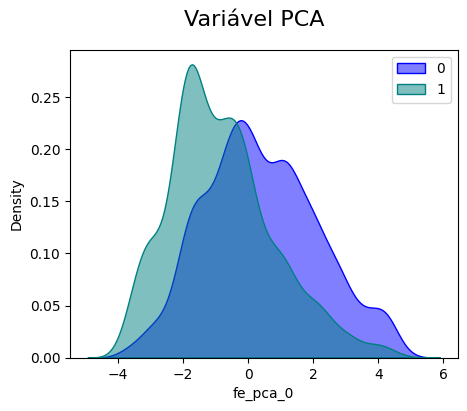

In [26]:
plt.figure(figsize=(5,4))

_ = df2_train.copy() 

sns.kdeplot(_[_[target]==0]['fe_pca_0'],color='blue', alpha=0.5, label='0', shade=True)
sns.kdeplot(_[_[target]==1]['fe_pca_0'],color='teal', alpha=0.5, label='1', shade=True)  
#plt.xlabel(feature, fontsize=12)
plt.legend()

plt.suptitle('Variável PCA ', fontsize=16);

In [27]:
def grup_pca (df_): 
    df_['fe_pca_0_group']= np.inf
    df_['fe_pca_0_group'][(df_['fe_pca_0']<-2) ]  = 'gr_1'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>=-2) & (df_['fe_pca_0']<=0)]= 'gr_2'
    df_['fe_pca_0_group'][(df_['fe_pca_0']>0) & (df_['fe_pca_0']<2)]  = 'gr_3'
    df_['fe_pca_0_group'][df_['fe_pca_0']>2]  = 'gr_4'
    df_.drop('fe_pca_0', axis=1, inplace=True)
    return df_

In [28]:
class AnalysisWoe():
    
    import numpy as np
    
    def __init__(self): 
        pass

    def iv_woe(self, data, target, bins=10, show_woe=False):

        newDF,woeDF = pd.DataFrame(), pd.DataFrame()

        cols = data.columns

        print()


        # Execute WOE e IV em todas as variáveis independentes
        for ivars in cols[~cols.isin([target])]:

            if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
                binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
                d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            else:
                d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})


            # Calcule o número de eventos em cada grupo (bin)
            d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
            d.columns = ['Cutoff', 'N', 'Events']

            # Calcule % de eventos em cada grupo.
            d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

            # alcule os não eventos em cada grupo.
            d['Non-Events'] = d['N'] - d['Events']
            # Calculate % of non events in each group.
            d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

            # Calcule WOE tomando o log natural da divisão de % de não eventos e % de eventos
            d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
            d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
            d.insert(loc=0, column='Variable', value=ivars)

            print("Valor da informação de " + ivars + " é " + str(round(d['IV'].sum(),6)))

            temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
            newDF=pd.concat([newDF,temp], axis=0)
            woeDF=pd.concat([woeDF,d], axis=0)

            #Show WOE Table
            if show_woe == True:
                display(d)
                print('\n\n\n')

        return newDF, woeDF

    def woe_categorical(self, df, cat_feature, good_bad_df):
        
        df = pd.concat([df[cat_feature], good_bad_df], axis=1)
        df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                        df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
        df = df.iloc[:, [0, 1, 3]]
        df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
        df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
        df['n_good'] = df['prop_good'] * df['n_obs']
        df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
        df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
        df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
        df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
        df = df.sort_values(['WoE'])
        df = df.reset_index(drop = True)
        df['diff_prop_good'] = df['prop_good'].diff().abs()
        df['diff_WoE'] = df['WoE'].diff().abs()
        df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
        df['IV'] = df['IV'].sum()
        return df

    def woe_continous(df, cat_feature, good_bad_df):
        df = pd.concat([df[cat_feature], good_bad_df], axis=1)
        df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                        df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
        df = df.iloc[:, [0, 1, 3]]
        df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
        df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
        df['n_good'] = df['prop_good'] * df['n_obs']
        df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
        df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
        df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
        df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
        df['diff_prop_good'] = df['prop_good'].diff().abs()
        df['diff_WoE'] = df['WoE'].diff().abs()
        df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
        df['IV'] = df['IV'].sum()
        return df
    
    def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
        
        import numpy as np
        
        x = np.array(df_WoE.iloc[:, 0].apply(str))
        y = df_WoE['WoE']
        plt.figure(figsize=(18, 12))
        plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
        plt.xlabel(df_WoE.columns[0])
        plt.ylabel('Weight of Evidence')
        plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
        plt.xticks(rotation = rotation_of_x_axis_labels) 
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

In [29]:
my_woe = AnalysisWoe()
_, _   = my_woe.iv_woe(df2_train, target, show_woe=False)


Valor da informação de trabalho é 0.139673
Valor da informação de estado civil é 0.023042
Valor da informação de educação é 0.042039
Valor da informação de atraso é 0.0
Valor da informação de casa é 0.003543
Valor da informação de empréstimo é 0.005874
Valor da informação de contato é 0.298627
Valor da informação de mês é 0.506185
Valor da informação de dia é 0.014075
Valor da informação de duração é 1.217434
Valor da informação de anterior é 0.399224
Valor da informação de idade_group é 0.13026
Valor da informação de ncontatos_group é 0.04608
Valor da informação de fe_pca_0 é 0.530298
Valor da informação de fe_cluster é 0.456678


In [32]:
_, __ = my_woe.iv_woe(df2_train[['fe_pca_0', target]], target, show_woe=True)


Valor da informação de fe_pca_0 é 0.530298


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,fe_pca_0,"(-3.9259999999999997, -2.14]",569,365,0.192714,204,0.053812,1.275716,0.177200
1,fe_pca_0,"(-2.14, -1.634]",568,299,0.157867,269,0.070958,0.799671,0.069499
2,fe_pca_0,"(-1.634, -1.099]",569,247,0.130412,322,0.084938,0.428776,0.019498
3,fe_pca_0,"(-1.099, -0.58]",568,221,0.116684,347,0.091533,0.242777,0.006106
4,fe_pca_0,"(-0.58, -0.172]",569,191,0.100845,378,0.099710,0.011318,0.000013
5,fe_pca_0,"(-0.172, 0.302]",568,160,0.084477,408,0.107623,-0.242155,0.005605
6,fe_pca_0,"(0.302, 0.955]",570,137,0.072334,433,0.114218,-0.456818,0.019133
7,fe_pca_0,"(0.955, 1.556]",567,106,0.055966,461,0.121604,-0.776020,0.050936
8,fe_pca_0,"(1.556, 2.465]",569,97,0.051214,472,0.124505,-0.888329,0.065107
9,fe_pca_0,"(2.465, 4.888]",568,71,0.037487,497,0.131100,-1.251971,0.117201


In [33]:
_, __ = my_woe.iv_woe(df2_train[['fe_cluster', target]], target, show_woe=True)


Valor da informação de fe_cluster é 0.456678


,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,fe_cluster,cluster_1,2163,1091,0.576030,1072,0.282775,0.711507,0.208653
1,fe_cluster,cluster_2,1632,315,0.166315,1317,0.347402,-0.736600,0.133389
2,fe_cluster,cluster_3,1381,427,0.225449,954,0.251649,-0.109941,0.002880
3,fe_cluster,cluster_4,509,61,0.032207,448,0.118175,-1.299981,0.111756


In [45]:
df2_train = grup_pca(df2_train)
df2_test  = grup_pca(df2_test)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. PIPELINE </h1>    
</div>

## 3.1. Split train/test

In [46]:
seed      = 12359
df3_train = df2_train.copy()
df3_test  = df2_test.copy()
X         = df2_train.drop(target, axis=1)
y         = df2_train[target]
X_test    = df2_test.copy()

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, 
                     test_size    = 0.2,
                     shuffle      = True, 
                     random_state = seed)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

((4548, 15), (4548,), (1137, 15), (1137,), (5685, 16))

In [47]:
counter          = Counter(y)
scale_pos_weight = (counter[0]/counter[1]) 

params_xgb  = {
    'objective'        : 'binary:logistic', 
    'eval_metric'      : ['error', 'logloss'],
    'max_depth'        : 5, 
    'scale_pos_weight' : scale_pos_weight,
    'n_estimators'     : 1000,    
    'learning_rate'    : .01,
    'colsample_bytree' : .75,    
    'subsample'        : .8,
    'reg_lambda'       : 30,
    'n_jobs'           : -1,    
    'seed'             : seed}
    
if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb  = xgb.XGBClassifier(**params_xgb)

In [ ]:
class KFoldTargetEncoderTrain(base.BaseEstimator,base.TransformerMixin):
    # https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] =    
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} 
                   is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        
        return X

In [ ]:
class TargetEncoderCV(TargetEncoder):
    """Cross-fold target encoder.
    """
    # https://brendanhasz.github.io/2019/03/04/target-encoding.html
    
    def __init__(self, n_splits=3, shuffle=True, cols=None):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.
        cols : list of str
            Columns to target encode.
        """
        self.n_splits = n_splits
        self.shuffle  = shuffle
        self.cols     = cols

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(cols=self.cols)
        self._target_encoder.fit(X, y)        
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix  = []
        self._fit_tes  = []
        kf             = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        
        for train_ix, test_ix in kf.split(X):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(cols=self.cols)
            
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:],
                                            y[train_ix]))
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')

        # Aplicar meios nas dobras
        Xo = X.copy()
        
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = \
                    self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = \
                    self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X deve ser DataFrame ou ndarray')
                
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
class TargetEncoderLOO(TargetEncoder):
    """Leave-one-out target encoder.
    """
    
    def __init__(self, cols=None):
        """Leave-one-out target encoding for categorical features.
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.
        """
        self.cols = cols
        
    def fit(self, X, y):
        """Fit leave-one-out target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to target encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.sum_count = dict()
        for col in self.cols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = \
                    (y[ix].sum(),ix.sum())
            
        # Return the fit object
        return self
    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses leave-one-out target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        # Create output dataframe
        Xo = X.copy()

        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = sum_count[0]/sum_count[1]
                Xo[col] = vals

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    vals[ix] = (sum_count[0]-y[ix])/(sum_count[1]-1)
                Xo[col] = vals
            
        # Return encoded DataFrame
        return Xo
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [ ]:
# https://www.kaggle.com/code/ffisegydd/sklearn-multicollinearity-class
class ReduceVIF(BaseEstimator, TransformerMixin):
    
    def __init__(self, thresh=5.0, impute=True, impute_strategy="median"):
        # Observando a documentação, valores entre 5 e 10 estão "ok".
        # Acima de 10 é muito alto e por isso deve ser removido.
        self.thresh = thresh

        # A função statsmodel falhará com valores NaN, como tal, temos que imputá-los.
        # Por padrão, imputamos usando o valor mediano.
        # Esta imputação pode ser retirada e adicionada como parte de um Pipeline sklearn.
        if impute:
            self.imputer = SimpleImputer(strategy='median') # Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):        
        if hasattr(self, "imputer"):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):        
        columns = X.columns.tolist()
        if hasattr(self, "imputer"):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        iter    = 0
        dropped = True
        
        while dropped:
            variables = X.columns
            dropped   = False
            exog      = X[variables].values
            exog_idx  = X.columns            
            vif       = [variance_inflation_factor(exog, exog_idx.get_loc(var))
                         for var in X.columns]
        
            iter    = iter + 1
            max_vif = max(vif)
            
            if max_vif>thresh:
                maxloc  = vif.index(max_vif)                
                X       = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped = True
                
        return X

In [ ]:
class Kimputer():
    
    def __init__(self, n_=10, weights_="uniform"):
        self.n       = n_
        self.weights = weights_
        self.cats    = ["product_code", "attribute_0", "attribute_1", "attribute_2", "attribute_3"]
        self.ints    = ["measurement_0", "measurement_1", "measurement_2"]
        
    def __imputer(self, X):
        knn_imp = KNNImputer(n_neighbors=self.n, weights=self.weights).fit_transform(X)        
        return pd.DataFrame(knn_imp, index=X.index, columns=X.columns)
    
    def fit(self, X, y=None):
        cats  = self.cats
        ints  = self.ints         
        right = pd.concat([self.__imputer(gdf.drop(columns=cats)) \
                           for g, gdf in X.groupby("product_code")], axis="rows")
        
        right[ints] = right[ints].round().astype(int)
        df = pd.concat([X[cats], right], axis="columns").reindex(columns=X.columns)
        return df
    
    def transform(self, X, y=None):
        return self.fit(X)        
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y)    

In [56]:
X.columns

Index(['trabalho', 'estado civil', 'educação', 'atraso', 'casa', 'empréstimo',
       'contato', 'mês', 'dia', 'duração', 'anterior', 'idade_group',
       'ncontatos_group', 'fe_cluster', 'fe_pca_0_group'],
      dtype='object')

In [57]:
cols_oho    = ['trabalho', 'estado civil', 'atraso', 'casa', 'empréstimo', 'ncontatos_group', 'anterior'] 
cols_ord    = ['educação', 'mês', 'dia', 'duração', 'fe_cluster', 'idade_group' ]
cols_woe    = ['fe_pca_0_group']
cols_target = []

In [58]:
# Preprocessing data:
numerical_transformer = SimpleImputer(strategy='constant')

transformer_ord = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('Ord', OrdinalEncoder())
])

transformer_nho = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),
    ('OHen',OneHotEncoder(handle_unknown='ignore',sparse=False))
])

transformer_woe = Pipeline(steps=[
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),    
    ('woe', ce.WOEEncoder(regularization=0))
])

transformer_tar = Pipeline(steps=[    
    ('imp',SimpleImputer(strategy='constant', fill_value='No Data')),   
    ('imputer', ce.LeaveOneOutEncoder())
])
    
processor=ColumnTransformer(
    transformers=[    
        ('ord', transformer_ord, cols_ord ),
        ('oho', transformer_nho, cols_oho), 
        ('woe', transformer_woe, cols_woe ),
        #('tar', transformer_tar, cols_target ),
        ], 
    remainder='drop', 
    sparse_threshold=0.3
)

percentage = .5
over       = SMOTE(sampling_strategy=percentage, k_neighbors=5, n_jobs=-1, random_state=seed) 
under      = RandomUnderSampler(sampling_strategy=percentage, random_state=seed)

# Processamento
selectKbest      = ('SelectKBest', SelectKBest(score_func=f_classif, k=12))
transf_column    = ('transform', processor)
var_threshold    = ('variancethreshold', VarianceThreshold(threshold=0.04)) 
sel_percentile   = ('selectpercentile', SelectPercentile(f_classif, percentile=85))
drop_feature_cor = ('dropfeaturecorr', DropConstantFeatures(tol=0.80))
scaler           = ('preprocessor', StandardScaler())

# Pipelne 
pipeline_processor = Pipeline(steps=[
    transf_column, 
    var_threshold, 
    sel_percentile, 
    drop_feature_cor,
    scaler
])

pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', model_xgb)])

pipeline_xgb

Pipeline(steps=[('processor',
                 Pipeline(steps=[('transform',
                                  ColumnTransformer(transformers=[('ord',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='constant')),
                                                                                   ('Ord',
                                                                                    OrdinalEncoder())]),
                                                                   ['educação',
                                                                    'mês',
                                                                    'dia',
                                                                    'duração',
                                                                    'fe_cluster',
                                                                    'idade_group']),
                                                                  ('oho',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='No '
                                                                                                             'Data',
                                                                                                  strategy='consta...
                               eval_metric=['error', 'logloss'], gamma=0,
                               gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.01, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=5, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=1000, n_jobs=-1,
                               num_parallel_tree=1, predictor='auto',
                               random_state=12359, reg_alpha=0, reg_lambda=30, ...))])

In [59]:
_ = processor.fit_transform(X,y)
col_origen = _.shape[1]
_ = pd.DataFrame(pipeline_processor.fit_transform(X,y))
col_end = _.shape[1]

print('Feature      : {}'.format(col_origen))
print('Feature final: {}'.format(col_end))

Feature      : 31
Feature final: 12


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;">4. TURNING </h1>    
</div>

In [64]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 4.1 Classe de turnning

In [65]:
class LastPlacePruner(BasePruner):
    # https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/006_user_defined_pruner.html#sphx-glr-tutorial-20-recipes-006-user-defined-pruner-py    
    def __init__(self, warmup_steps, warmup_trials):
        self._warmup_steps = warmup_steps
        self._warmup_trials = warmup_trials

    def prune(self, study: "optuna.study.Study", trial: "optuna.trial.FrozenTrial") -> bool:
        # Obtenha a pontuação mais recente relatada neste teste
        step = trial.last_step

        if step:  # trial.last_step == None when no scores have been reported yet
            this_score = trial.intermediate_values[step]

            # Get scores from other trials in the study reported at the same step
            completed_trials = study.get_trials(deepcopy=False, states=(TrialState.COMPLETE,))
            other_scores = [
                t.intermediate_values[step]
                for t in completed_trials
                if step in t.intermediate_values
            ]
            other_scores = sorted(other_scores)

            # Prune if this trial at this step has a lower value than all completed trials
            # at the same step. Note that steps will begin numbering at 0 in the objective
            # function definition below.
            if step >= self._warmup_steps and len(other_scores) > self._warmup_trials:
                if this_score < other_scores[0]:
                    #print(f"prune() True: Trial {trial.number}, Step {step}, Score {this_score}")
                    return True

        return False

In [66]:
class TunningModels(): # nn.Module
        
    def __init__(self, name_model_, X_trn_, y_trn_, X_ts_, target_,
                 seed_=12359, path_='', level_='1', sc_second_= None, 
                 n_splits_=10, verbose_=False):
        
        super(TunningModels,self).__init__() 

        self.name_clf    = name_model
        self.X_trn       = X_trn_
        self.y_trn       = y_trn_
        self.X_ts        = X_ts_                 
        self.seed        = seed_
        self.target      = target_
        self.path        = path_
        self.level       = level_
        self.sc_second   = sc_second_
        self.n_splits    = n_splits_
        self.verbose     = verbose_ 
        
    def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))
                        
    def xgb(self,  trial):

        # https://xgboost.readthedocs.io/en/latest/parameter.html
        # https://amangupta16.medium.com/xgboost-hyperparameters-explained-bb6ce580501d     
        # https://aetperf.github.io/2021/02/16/Optuna-+-XGBoost-on-a-tabular-dataset.html
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        # https://github.com/optuna/optuna/issues/2793
        # https://programtalk.com/python-more-examples/optuna.integration.XGBoostPruningCallback/
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
        
        params = {
            'objective'         : trial.suggest_categorical('objective', ['binary:logistic']),
            'eval_metric'       : trial.suggest_categorical('eval_metric', ['error']), 
            'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', scale_pos_weight, scale_pos_weight),
            'max_depth'         : trial.suggest_int('max_depth', 2, 10),                   
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 1500, 100),                       
            'learning_rate'     : trial.suggest_float('learning_rate', .0001, 0.1),
            'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05),
            'reg_lambda'        : trial.suggest_int('reg_lambda', 1, 100, 10), 
            'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 10), 
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'seed'              : trial.suggest_int('seed', self.seed, self.seed)
        }
            
        if torch.cuda.is_available():           
            params.update(
                {'tree_method': trial.suggest_categorical('tree_method', ['gpu_hist']),
                 'predictor'  : trial.suggest_categorical('predictor', ['gpu_predictor'])}
            )
                           
              
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-error')
        
        pruning_callback = XGBoostPruningCallback(trial, 'validation_0-error') # + evalMetric)
                
        mdl          = xgb.XGBClassifier(**params)        
        pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models       = [('XGB', pipeline_xgb, 1, self.name_clf , pipeline_processor, 15)]
        
        #models       = [('XGB-1', mdl, 5, self.name_clf , pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.target,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True, 
                         #callbacks_    = pruning_callback
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def lgbm(self,  trial):
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
        
        params = {
            'objective'         : trial.suggest_categorical('objective', ['binary']),
            'metric'            : trial.suggest_categorical('metric', ['binary_logloss']),             
            'scale_pos_weight'  : trial.suggest_float('scale_pos_weight', scale_pos_weight, scale_pos_weight),
            'colsample_bytree'  : trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'learning_rate'     : trial.suggest_float('learning_rate', .00001, 0.1),
            'max_depth'         : trial.suggest_int('max_depth', 2, 10),                   
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 2500, 100),                       
            'min_child_weight'  : trial.suggest_int('min_child_weight', 1, 20), 
            'subsample'         : trial.suggest_discrete_uniform('subsample', .7, 1.0, .05),
            'reg_lambda'        : trial.suggest_int('reg_lambda', 1, 100, 10), 
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'random_state'      : trial.suggest_int('seed', self.seed, self.seed)
        }
                
        mdl      = lgb.LGBMClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('LGBM-1', pipeline, 1, self.name_clf , pipeline_processor, 15)]
       
       
        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.target,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True, 
                         #callbacks_    = pruning_callback
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
        
    def ext(self,  trial):
        # https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-xtra-trees
        
        counter          = Counter(self.y_trn)
        scale_pos_weight = (counter[0]/counter[1]) 
                        
        params = {                 
            'criterion'         : trial.suggest_categorical('criterion', ['gini']),
            'n_estimators'      : trial.suggest_int('n_estimators', 100, 2000, 100),
            'max_depth'         : trial.suggest_int('max_depth', 2, 15),            
            'class_weight'      : trial.suggest_categorical('class_weight', ['balanced']),
            'bootstrap'         : trial.suggest_categorical('bootstrap', [True]),
            'oob_score'         : trial.suggest_categorical('oob_score', [True]),
            'warm_start'        : trial.suggest_categorical('warm_start', [True]),            
            'n_jobs'            : trial.suggest_int('n_jobs', -1, -1 ), 
            'random_state'      : trial.suggest_int('seed', self.seed, self.seed)
        }
                       
        mdl      = ExtraTreesClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('Extra-Trees', pipeline, 1, self.name_clf , pipeline_processor, 15)]
       
       
        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.target,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True, 
                         #callbacks_    = pruning_callback
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def hgb(self,  trial):
                               
        params = {                       
            'scoring'             : trial.suggest_categorical('scoring', ['loss']),
            'max_depth'           : trial.suggest_int('max_depth', 2, 7),               
            'max_iter'            : trial.suggest_int('max_iter', 100, 1000, 50),
            'learning_rate'       : trial.suggest_float('learning_rate', .001, 1.),
            'early_stopping'      : trial.suggest_int('early_stopping', 30, 30),
            'validation_fraction' : trial.suggest_float('validation_fraction', .5, .5),
            'l2_regularization'   : trial.suggest_float('l2_regularization', .05, 1),
            #'warm_start'          : trial.suggest_categorical('warm_start', [True]),
            'random_state'        : trial.suggest_int('random_state', self.seed, self.seed)
        }
                      
        mdl      = HistGradientBoostingClassifier(**params)
        pipeline = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models   = [('Extra-Trees', pipeline, 1, self.name_clf , pipeline_processor, 15)]
               
        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.target,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True, 
                         #callbacks_    = pruning_callback
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score
    
    def mlp(self,  trial):
         
        hidden_layers = [(10,15),(10,20),(10,25),(10,50),(10,20,30),(25,50,50,75)]
        
        params = {
            'hidden_layer_sizes' : trial.suggest_categorical('hidden_layer_sizes', hidden_layers),
            'activation'         : trial.suggest_categorical('activation', ["relu", "identity"]),
            'learning_rate'      : trial.suggest_categorical('learning_rate', ['constant','invscaling','adaptive']),
            'learning_rate_init' : trial.suggest_float('learning_rate_init', 0.001, 0.01),
            'random_state'       : trial.suggest_int('random_state', self.seed, self.seed)
        }
                
        mdl          = MLPClassifier(**params)       
        pipeline_xgb = Pipeline(steps=[('processor', pipeline_processor), ('model', mdl)])                        
        models       = [('MLP', pipeline_xgb, 1, self.name_clf , pipeline_processor, 15)]

        mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
            model_cv_fit(models_       = models, 
                         X_            = self.X_trn,
                         y_            = self.y_trn, 
                         X_test_       = self.X_ts,                  
                         path_         = self.path, 
                         seed_         = self.seed,
                         target_       = self.target,
                         create_sub_   = True, 
                         n_splits_     = self.n_splits,
                         print_report_ = True, 
                         is_tunning_   = True
                        )

        if self.verbose:
            print('score: {:5f} => param = {}'.format(score, params))            
            print()

        return score    

## 4.2. Modelo XGB

In [67]:
%%time 

models = [('XGB', pipeline_xgb, 1, 'xgb_tun_06_pp', pipeline_processor, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

# F1-score: 0.72946 - F1-Train: 0.75125 - L.Loss: 0.42910 - 0h 0m 13s


=> XGB
Fold 1 => F1-score: 0.68835 - F1-Train: 0.72370 - AUC:0.76925 - L.Loss: 0.47687 - 0h 0m 1s
Fold 2 => F1-score: 0.73224 - F1-Train: 0.75145 - AUC:0.80878 - L.Loss: 0.44376 - 0h 0m 1s
Fold 3 => F1-score: 0.73879 - F1-Train: 0.74582 - AUC:0.81696 - L.Loss: 0.42749 - 0h 0m 1s
Fold 4 => F1-score: 0.72881 - F1-Train: 0.74727 - AUC:0.80388 - L.Loss: 0.40820 - 0h 0m 1s
Fold 5 => F1-score: 0.69851 - F1-Train: 0.72079 - AUC:0.77596 - L.Loss: 0.46213 - 0h 0m 1s
Fold 6 => F1-score: 0.69923 - F1-Train: 0.74954 - AUC:0.77888 - L.Loss: 0.46758 - 0h 0m 1s
Fold 7 => F1-score: 0.69663 - F1-Train: 0.74855 - AUC:0.77443 - L.Loss: 0.45350 - 0h 0m 1s
Fold 8 => F1-score: 0.72113 - F1-Train: 0.74433 - AUC:0.79578 - L.Loss: 0.43039 - 0h 0m 1s
Fold 9 => F1-score: 0.75843 - F1-Train: 0.74063 - AUC:0.82984 - L.Loss: 0.40173 - 0h 0m 1s
Fold 10 => F1-score: 0.70341 - F1-Train: 0.72582 - AUC:0.78350 - L.Loss: 0.48503 - 0h 0m 1s
---------------------------------------------------------------------------------

,score
XGB,0.71655


CPU times: total: 1min 46s
Wall time: 14.5 s


In [ ]:
%%time
n_trials_  = 100
name_clf   = 'xgb'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,   
                         seed_           = seed, 
                         target_         = target, 
                         path_           = path, 
                         n_splits_       = 10,
                         level_          = '1')

pruner = LastPlacePruner(warmup_steps  = 1, warmup_trials=5)

study_xgb  = optuna.create_study(direction  = 'maximize',
                                 sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                 pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                 study_name = 'xgb_turning')

study_xgb.optimize(modelOpt.xgb, n_trials=n_trials_)

score_seed         = study_xgb.best_value 
params_xgb_turning = study_xgb.best_params 
path_name          = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best         = score_seed 

jb.dump(study_xgb, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_xgb_turning))
print()

### 4.2.1. Treinar o modelo com novos parametros 

In [ ]:
%%time 

# Pipelne 
pipeline_processor_turning = Pipeline(steps=[
    transf_column, 
    var_threshold, 
    sel_percentile, 
    drop_feature_cor,
    scaler
])

if torch.cuda.is_available():           
    params_xgb_turning.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_xgb_turning  = xgb.XGBClassifier(**params_xgb_turning)

pipeline_xgb_turning = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_xgb_turning)])

models = [('XGB', pipeline_xgb_turning, 1, 'xgb_tun_07_pp', pipeline_xgb_turning, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True
                )

# F1-score: 0.72946 - F1-Train: 0.75125 - L.Loss: 0.42910 - 0h 0m 13s
# F1-score: 0.73017 - F1-Train: 0.75289 - L.Loss: 0.42971 - 0h 0m 15s

_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))
print()

Acima treinamos o modelo com os novos parametros, agora vamos fazer um teste com os dados que não foram utilizados no treinamento. Vamos recupara um dos modelos que foi aramzenado em <b>mdl_list_fit</b>. 

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos um overfitting significativos com o ajustes dos parametros, quando olhamos para as previsões feitas nos daos que o modelo não viu no treinamento.  
    
</div>

### 4.4.2. Análise do turning 

Nesta seção, exploraremos várias visualizações disponíveis no Optuna que podem nos ajudar a tomar melhores decisões. Ele nos fornece vários hiperparâmetros e seu impacto no desempenho do modelo.


Começaremos verificando se o suporte à visualização está disponível ou não usando a função is_available(). Ele verifica se as versões apropriadas de plotly e matplotlib estão disponíveis ou não para criar visualizações.

#### 4.4.2.1. Visualizações de dados 

#### 4.4.2.2. Histórico de Otimização 

O primeiro gráfico que apresentaremos é o gráfico do histórico de otimização. Ele plota o número de tentativas que tentamos para encontrar a melhor combinação de hiperparâmetros no eixo Y e um valor objetivo que obtivemos para cada tentativa no eixo Y.

Podemos usar este gráfico para verificar se a otimização de hiperparâmetros está indo na direção certa ou não.


In [ ]:
plot_optimization_history(study_xgb, target_name="F1-score")

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos observar no gráfico acima que o valor de F1-score aumenta com o aumento das tentativas, isso confirma que a Optuna estava procurando uma combinação de hiperparâmetros na direção certa. No nosso caso o númro de tentativas ideais seria em torno de 60.

</div>

#### 4.4.2.3. Importância de prâmetros

O segundo gráfico que traçaremos é um gráfico de barras que representa a importância dos hiperparâmetros de hiperparâmetros cujas combinações foram tentadas durante o processo de otinização. Isso pode nos ajudar a entender quais hiperparâmetros estão contribuindo mais para minimizar/maximizar o valor objetivo.

In [ ]:
params_optuna =['learning_rate', 'reg_lambda', 'min_child_weight', 
                'max_depth', 'colsample_bytree', 'n_estimators', 
                'subsample']
                
#plot_param_importances(study_xgb, params=params_optuna, target_name='F1-score')

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos notar que learning_rate é o parâmetro mais importante para otimizar, seguido por reg_lambda.

</div>

#### 4.4.2.4. Coordenadas Paralelas de Relacionamento

In [ ]:
plot_parallel_coordinate(study_xgb, params=params_optuna, target_name = "F1-scaore" )

In [ ]:
plot_slice(study_xgb,  params=params_optuna)

#### 4.5.2.5. Distribuição empírica 

In [ ]:
optuna.visualization.plot_edf(study_xgb, target_name="F1-score", )

## 4.3. Modelo LBGM

In [ ]:
%%time 

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.8,
    'learning_rate'     : 0.1,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

model_lgbm   = lgb.LGBMClassifier(**param_lgbm)
pipeline_lgbm = Pipeline(steps=[('processor', pipeline_processor), ('model', model_lgbm)])

models = [('LBGM', pipeline_lgbm, 1, 'lgbm_tun_08_pp', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)


### 4.3.2. Turning

In [ ]:
%%time
n_trials_  = 100
name_clf   = 'lgbm'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,   
                         seed_           = seed, 
                         target_         = target, 
                         path_           = path, 
                         n_splits_       = 10,
                         level_          = '1')

study_lbgm  = optuna.create_study(direction  = 'maximize',
                                  sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                  pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                  study_name = 'lbgm_turning')

study_lbgm.optimize(modelOpt.lgbm, n_trials=n_trials_)

score_seed         = study_lbgm.best_value 
params_lgb_turning = study_lbgm.best_params 
path_name          = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best         = score_seed 

jb.dump(study_lbgm, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_lgb_turning))
print()

In [ ]:
# Classificadores
model_lgb_turning  = lgb.LGBMClassifier(**params_lgb_turning)

pipeline_lgb_turning = Pipeline(steps=[('processor', pipeline_processor_turning), ('model', model_lgb_turning)])

models = [('LGBM', pipeline_lgb_turning, 1, 'lgbm_tun', pipeline_processor_turning, 15)]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))

## 4.5. Modelo HistGradientBoosting

In [ ]:
%%time 

param_hbc   = {
    'scoring'             : 'loss',
    'max_depth'           : 5, 
    'max_iter'            : 500,
    'learning_rate'       : .1,    
    'validation_fraction' : .5,
    'l2_regularization'   : .10,
    'early_stopping'      : 30,
    #'warm_start'          : True,
    'random_state'        : seed}

model_hbc    = HistGradientBoostingClassifier(**param_hbc)
pipeline_hbc = Pipeline(steps=[('processor', pipeline_processor), ('model', model_hbc)])

models = [('HGB', pipeline_hbc, 1, 'hbc_tun_09_pp', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

### 4.4.2. Turning 

In [ ]:
%%time
n_trials_  = 50
name_clf   = 'hgb'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,   
                         seed_           = seed, 
                         target_         = target, 
                         path_           = path, 
                         n_splits_       = 10,
                         level_          = '1')

study_hgb = optuna.create_study(direction  = 'maximize',
                                sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                study_name = 'ext_turning')

study_hgb.optimize(modelOpt.hgb, n_trials=n_trials_)

score_seed          = study_hgb.best_value 
params_hgb_turning  = study_hgb.best_params 
path_name           = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best          = score_seed 

jb.dump(study_hgb, path_name)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_hgb_turning))
print()

### 4.2.1. Treinar o modelo com os parametros 

In [ ]:
model_hgb_turning    = HistGradientBoostingClassifier(**params_hgb_turning)
pipeline_hgb_turning = Pipeline(steps=[('processor', pipeline_processor), ('model', model_hgb_turning)])

models = [('HGB', pipeline_hgb_turning, 1, 'hbc_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score valid: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))

## 4.5. Modelo MLP

In [ ]:

def objective(trial):
    hidden_layers = trial.suggest_categorical("hidden_layer_sizes", [(50,100),(100,100),(50,75,100),(25,50,75,100)])
    activation = trial.suggest_categorical("activation", ["relu", "identity"])
    #solver = trial.suggest_categorical("solver", ["sgd", "adam"])
    learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive'])
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.001, 0.01)

    ## Create Model
    mlp_regressor = MLPRegressor(
                            hidden_layer_sizes=hidden_layers,
                            activation=activation,
                            #solver=solver,
                            learning_rate=learning_rate,
                            learning_rate_init=learning_rate_init,
                            #early_stopping=True
                            )
    ## Fit Model
    for i, (X_batch, Y_batch) in enumerate(zip(X_train_batched,Y_train_batched)):
        mlp_regressor.partial_fit(X_batch, Y_batch)

        mse = mean_squared_error(Y_test, mlp_regressor.predict(X_test))

        trial.report(mse, i+1)

        if trial.should_prune():
            raise optuna.TrialPruned()

    return mse

In [ ]:
params_mlp ={'hidden_layer_sizes': (10, 30), 
             'activation'        : 'relu', 
             'learning_rate'     : 'adaptive', 
             'learning_rate_init': 0.002328157655827371, 
             'random_state'      : 12359} 

model_mlp    = MLPClassifier(**params_mlp)    
pipeline_mlp = Pipeline(steps=[('processor', pipeline_processor), ('model', model_mlp)])

models = [('MLP', pipeline_mlp, 1, 'mlp_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

### 4.2.1. Turnning

In [ ]:
%%time
n_trials_  = 10
name_clf   = 'mlp'
name_model = '{}_001_turning'.format(name_clf) 

TunningModels.delete_files(name_model)
    
modelOpt = TunningModels(name_model_     = name_model, 
                         X_trn_          = X, 
                         y_trn_          = y, 
                         X_ts_           = X_test,   
                         seed_           = seed, 
                         target_         = target, 
                         path_           = path, 
                         n_splits_       = 10,
                         level_          = '1')

study_mlp = optuna.create_study(direction  = 'maximize',
                                sampler    = optuna.samplers.TPESampler(multivariate=True, seed=seed),
                                pruner     = optuna.pruners.MedianPruner(n_warmup_steps=10),
                                study_name = 'ext_turning')

study_mlp.optimize(modelOpt.mlp, n_trials=n_trials_)

score_seed          = study_mlp.best_value 
params_mlp_turning  = study_mlp.best_params 
path_name           = path + 'model/optuna/' + name_model + '_{:2.5f}.pkl.z'.format(score_seed)   
scare_best          = score_seed 

jb.dump(study_mlp, params_mlp_turning)

print()
print('-'*110)
print('Best score: {:2.5f}'.format(scare_best))
print('Seed      : {}'.format(seed))
print('Parameters:\n\n{}'.format(params_mlp_turning))
print()

### 4.2.2. Treinar o modelo com novos parametros 

In [ ]:
model_mlp_turning    = MLPClassifier(**params_mlp_turning)
pipeline_mlp_turning = Pipeline(steps=[('processor', pipeline_processor), ('model', model_mlp_turning)])

models = [('MLP', pipeline_mlp_turning, 1, 'mlp_tun', pipeline_processor, 15) ]
    
mdl_list_fit, df_pred_tr, df_pred_ts, df_score_mdl, score = \
    model_cv_fit(models_       = models, 
                 X_            = X_train,
                 y_            = y_train, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = target,
                 create_sub_   = False, 
                 n_splits_     = 10,
                 print_report_ = True)

_ = mdl_list_fit[0][2]
display(_)

print('F1-score: {:5f}'.format(f1_score(y_valid, _.predict(X_valid))))

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>

![](img/rank_final.jpg)

![](img/subs.jpg)